# Chapter One: Feature engineering and Preprocessing

In [20]:
# !pip uninstall -y typing_extensions
!pip install -U pydantic spacy typing_extensions --user

In [21]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

import spacy
from collections import Counter

from imblearn.over_sampling import RandomOverSampler

In [22]:
DATA_SOURCE = 'data/covid.zip'

In [23]:
df = pd.read_csv(DATA_SOURCE)
df.head()

,headlines,outcome
0,A post claims compulsory vacination violates t...,0
1,A photo claims that this person is a doctor wh...,0
2,Post about a video claims that it is a protest...,0
3,All deaths by respiratory failure and pneumoni...,0
4,The dean of the College of Biologists of Euska...,0


The dataset, as you can see, is really really simple: it's a piece of text and a label, that's it. In the age of transformers, we can very easily slap this data into a model and get some results. But, that would be no fun isn't it? So let's see what kinds of features we can extract from this a chunk of text and see if we can combine these features with a transformer model to get better results.

## Part 1: Feature engineering

### Add feature that counts the number of words in each headlines

In [24]:
def plot_hist_by_outcome(df, col, bins=10):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
    axes[0].hist(df[df['outcome'] == 0][col], bins=bins)
    axes[1].hist(df[df['outcome'] == 1][col], bins=bins)
    # subplots share the same x-axis range, and the y-axis range is automatically adjusted
    axes[0].set_title('Real News')
    axes[1].set_title('Fake News')
    fig.suptitle(col)
    
    plt.show()



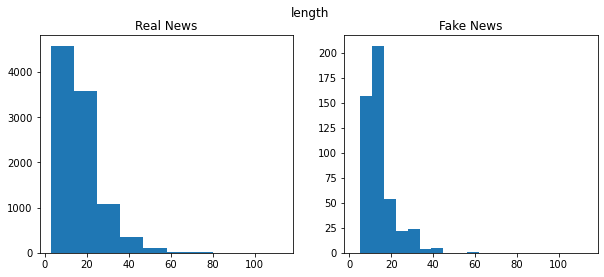

In [25]:
df['length'] = df['headlines'].apply(lambda x: len(x.split()))
plot_hist_by_outcome(df, 'length', bins=10)

We can see that fake news tend to be slightly shorter in words. This may be because fake news are more likely to be clickbait, and clickbait headlines tend to be shorter. However, this is not a very strong indicator, as the difference is not very significant.

### Add boolean feature that indicate if headline included statistics

In [26]:
def bar_chart_by_outcome(df, col):
    # count % of col values in each outcome
    df = df.groupby([col, 'outcome']).count().reset_index().pivot(index='outcome', columns=col, values='headlines')
    df = df.div(df.sum(axis=1), axis=0) * 100
    df.plot.bar(figsize=(8, 4))
    plt.title('% of {} in each outcome'.format(col))

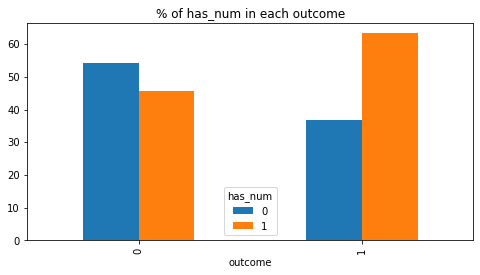

In [27]:
df['has_num'] = df['headlines'].str.contains(r'\d', regex=True).astype(int)
bar_chart_by_outcome(df, 'has_num')

Seems like fake news are more likely to include statistics in their headlines. Perhaps fake news sites are more likely to use statistics to make their headlines seem more credible.

### Add categorical features with Name-Entity Recognition using SpaCy and extract count of each entity labels

In [28]:
nlp = spacy.load('en_core_web_sm')

# @np.vectorize
def ner(text):
    doc = nlp(text)
    labels = [X.label_ for X in doc.ents]
    return Counter(labels)

df['ner'] = df['headlines'].apply(ner)
df.head()

,headlines,outcome,length,has_num,ner
0,A post claims compulsory vacination violates t...,0,30,1,{'ORG': 2}
1,A photo claims that this person is a doctor wh...,0,24,1,"{'ORG': 1, 'FAC': 1, 'GPE': 1}"
2,Post about a video claims that it is a protest...,0,20,0,{'ORG': 1}
3,All deaths by respiratory failure and pneumoni...,0,18,1,{'ORG': 2}
4,The dean of the College of Biologists of Euska...,0,24,0,{'ORG': 2}


In [29]:
labels = [list(c.keys()) for c in df.ner.values]
labels = set([item for sublist in labels for item in sublist])

for label in labels:
    df['ner_' + label.lower()] = df['ner'].apply(lambda x: x.get(label, 0)).sum()
df = df.drop(columns=['ner'])
df.head()
    


,headlines,outcome,length,has_num,ner_percent,ner_quantity,ner_law,ner_person,ner_product,ner_gpe,...,ner_time,ner_cardinal,ner_org,ner_money,ner_language,ner_ordinal,ner_event,ner_loc,ner_fac,ner_norp
0,A post claims compulsory vacination violates t...,0,30,1,151,40,22,3009,257,5308,...,233,1832,5566,153,18,196,37,192,137,2358
1,A photo claims that this person is a doctor wh...,0,24,1,151,40,22,3009,257,5308,...,233,1832,5566,153,18,196,37,192,137,2358
2,Post about a video claims that it is a protest...,0,20,0,151,40,22,3009,257,5308,...,233,1832,5566,153,18,196,37,192,137,2358
3,All deaths by respiratory failure and pneumoni...,0,18,1,151,40,22,3009,257,5308,...,233,1832,5566,153,18,196,37,192,137,2358
4,The dean of the College of Biologists of Euska...,0,24,0,151,40,22,3009,257,5308,...,233,1832,5566,153,18,196,37,192,137,2358


## Part 2: Class imbalance
One of the biggest challenges with modeling is rare events. If of of the classes we try to predict is very scarce in the data, it makes the model pretty biased even if the dataset is huge. With that in mind, let's do a quick count of the number of examples in each class.

In [30]:
def plot_count_of_each_outcome(df):
    df.groupby('outcome').count().headlines.plot.bar(figsize=(4, 4))
    plt.title('Number of news headlines in each outcome')

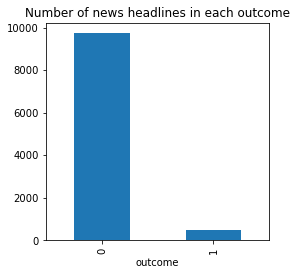

In [31]:
plot_count_of_each_outcome(df)

Oof! Very imbalanced. This tend to result in model having severe bias towards the majority class. We will need to do something about this. One way to do this is to oversample the minority class. We can do this by simply duplicating some of the examples in the minority class.

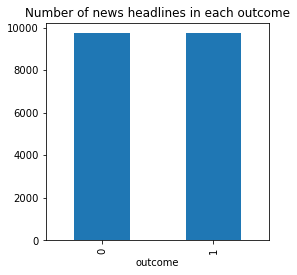

In [32]:
# use smote to oversample outcome == 1 class


X = df.drop(columns=['outcome'])
y = df['outcome']

ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
X, y = ros.fit_resample(X, y)

df = pd.concat([X, y], axis=1)
plot_count_of_each_outcome(df)

`# TODO: Insert thanos perfectly balanced meme`

## Part 3: Distribute dataset and save to the ☁️☁️
The dataset is pretty small, we could have easily load the whole thing in memory and train on it. However, as I've asked before, what is the fun in that? 

One of the cool things we can do to a dataset is that we don't need to keep it as a single file. We can split it into multiple files and save it to the cloud. This is useful because we can then load the data in parallel and train on it. Image we have a big ass dataset instead, there will be quite a huge problem if the dataset becomes too big to be fully loaded into memory. By spliting the files up, we can allow data to be trained in batches, and only a single batch of data is loaded each weight update.

In [33]:
BATCH_SIZE = 16
BUCKET_NAME = 'xy-mp-pipeline'
OUTPUT_PATH = 'data/covid-csv'

Here, we want to split the data into train and test and store them in different directories, then within each folder, we save a file containing 16 examples each.

In [34]:
def train_test_split(df, test_size=0.2):
    for col in df.columns:
        if col not in ['outcome', 'headlines']:
            df[col] = df[col].astype(float)
    positive = df[df['outcome'] == 1]
    negative = df[df['outcome'] == 0]

    n_pos = len(positive)
    n_neg = len(negative)

    negative_test = negative.iloc[:int(n_neg * test_size)]
    negative_train = negative.iloc[int(n_neg * test_size):]
    positive_test = positive.iloc[:int(n_pos * test_size)]
    positive_train = positive.iloc[int(n_pos * test_size):]

    train_df = pd.concat([positive_train, negative_train])
    test_df = pd.concat([positive_test, negative_test])
    return train_df, test_df
 
def write_csvs(df, folder, output_path, batch_size):
    if not os.path.exists(output_path + '/' + folder):
        os.makedirs(output_path + '/' + folder)

    for i in range(0, len(df), batch_size):
        batch = df.iloc[i:i+batch_size]
        batch.to_csv(f'{output_path}/{folder}/file{i}.csv', index=False)

def write_files_to_s3(output_path, bucket_name):
    !aws s3 rm --recursive s3://$bucket_name/$output_path
    !aws s3 cp --recursive $output_path s3://$bucket_name/$output_path

In [35]:
train_df, test_df = train_test_split(df)
train_len, test_len = len(train_df), len(test_df)
write_csvs(train_df, 'training', OUTPUT_PATH, BATCH_SIZE)
write_csvs(test_df, 'testing', OUTPUT_PATH, BATCH_SIZE)

write_files_to_s3(OUTPUT_PATH, BUCKET_NAME)

delete: s3://xy-mp-pipeline/data/covid-csv/testing/file1024.csv
delete: s3://xy-mp-pipeline/data/covid-csv/testing/file1008.csv
delete: s3://xy-mp-pipeline/data/covid-csv/testing/file1071.csv
delete: s3://xy-mp-pipeline/data/covid-csv/testing/file0.csv
delete: s3://xy-mp-pipeline/data/covid-csv/testing/file1072.csv
delete: s3://xy-mp-pipeline/data/covid-csv/testing/file1056.csv
delete: s3://xy-mp-pipeline/data/covid-csv/testing/file1040.csv
delete: s3://xy-mp-pipeline/data/covid-csv/testing/file1216.csv
delete: s3://xy-mp-pipeline/data/covid-csv/testing/file1104.csv
delete: s3://xy-mp-pipeline/data/covid-csv/testing/file1152.csv
delete: s3://xy-mp-pipeline/data/covid-csv/testing/file1136.csv
delete: s3://xy-mp-pipeline/data/covid-csv/testing/file1184.csv
delete: s3://xy-mp-pipeline/data/covid-csv/testing/file1168.csv
delete: s3://xy-mp-pipeline/data/covid-csv/testing/file1134.csv
delete: s3://xy-mp-pipeline/data/covid-csv/testing/file1232.csv
delete: s3://xy-mp-pipeline/data/covid-csv/

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19454 entries, 0 to 19453
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   headlines        19454 non-null  object
 1   length           19454 non-null  int64 
 2   has_num          19454 non-null  int32 
 3   ner_percent      19454 non-null  int64 
 4   ner_quantity     19454 non-null  int64 
 5   ner_law          19454 non-null  int64 
 6   ner_person       19454 non-null  int64 
 7   ner_product      19454 non-null  int64 
 8   ner_gpe          19454 non-null  int64 
 9   ner_work_of_art  19454 non-null  int64 
 10  ner_date         19454 non-null  int64 
 11  ner_time         19454 non-null  int64 
 12  ner_cardinal     19454 non-null  int64 
 13  ner_org          19454 non-null  int64 
 14  ner_money        19454 non-null  int64 
 15  ner_language     19454 non-null  int64 
 16  ner_ordinal      19454 non-null  int64 
 17  ner_event        19454 non-null